# Introduction

### Flower Recognition
I love to hike. One of the things I love most about hiking is gazing upon the many different varieties of flowers seen in nature, however, I have always been bad at recognizing different types of flowers (even some of the more easily recognizable ones). For this reason, I thought "why not build a neural network that can classify images of flowers?" By building an neural network that can classify the image of any flower that I give it, I hope that I will be able to start to improving my own flower recognition capabilities as well! In this notebook I use the [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) data set which is comprised of flower images from Flickr, Google images, and Yandex images to train a neural network to classify images of 5 different types of flowers. While this is a small number of flowers to recognize given the many many different species of flowers that actually exist in nature, I hope to eventually add many more images of different types of flowers to the training set to increase the number of flower species it can classify. I will use Tensorflow to build a Convolutional Neural Network to approach this problem.

### Import all required packages

In [1]:
# Importing all packages I will use throughout this notebook
import numpy as np
import pandas as pd 
import os
import PIL
import matplotlib.pyplot as plt
from IPython import display
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework import ops
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
path = '../input/flowers-recognition/flowers/'

## Exploring the image data

Let's explore the data set. The data is in 1 of 5 folders: 'daisy', 'dandelion', 'rose', 'sunflower', and 'tulip'. Each folder has roughly ~800-1000 images. Let's have a look at 20 randomly selected images from the full data set.

In [2]:
## Define function to plot 20 random images from list_of_images
def show_random_images(path, labels):
    for i in range(20):
        label_idx = random.randint(0, len(labels)-1) # Select folder at random to choose from
        im_path = path + labels[label_idx] + '/'
        image_idx = random.randint(0, len([name for name in os.listdir(im_path)])-1) # Select image at random from folder
        image_names = [name for name in os.listdir(im_path) ]
        plt.subplot(4,5,i+1).set_title(labels[label_idx])
        plt.imshow(PIL.Image.open(im_path + image_names[image_idx]))

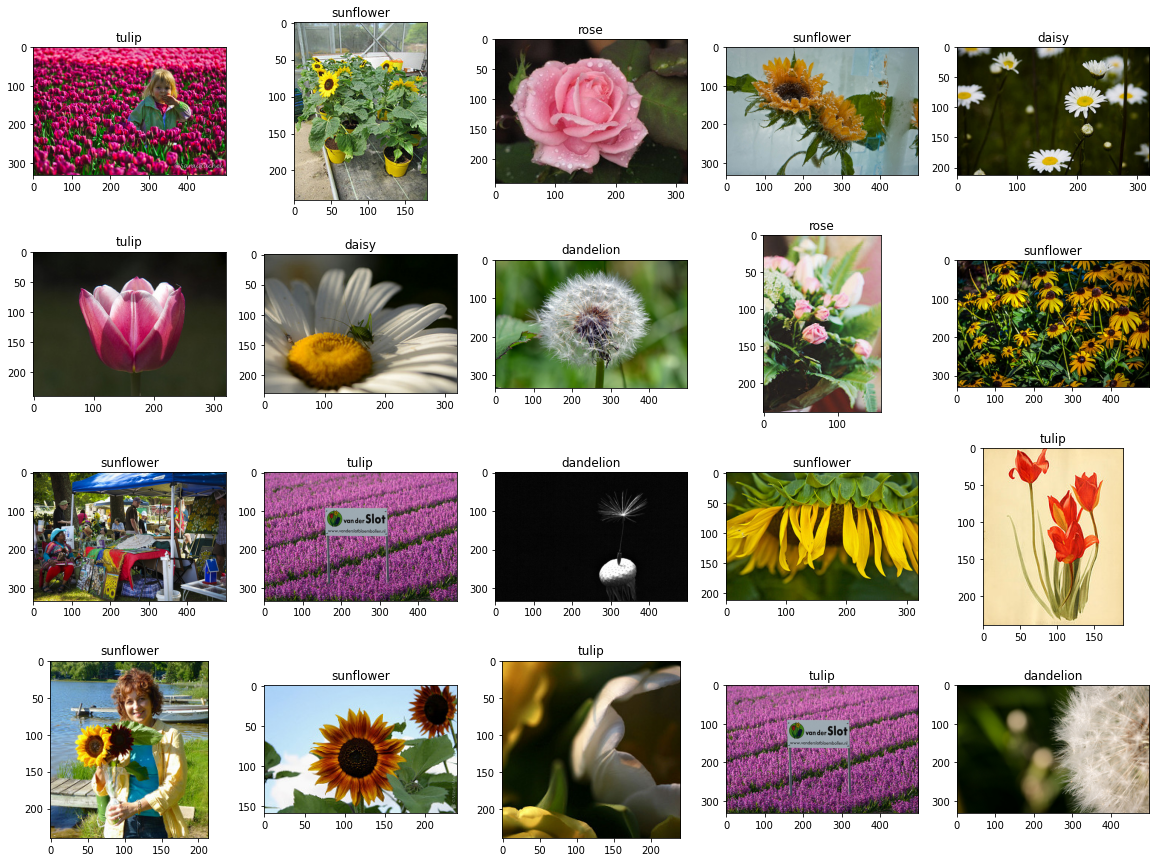

In [3]:
path = '../input/flowers-recognition/flowers/'
flowers = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

show_random_images(path, flowers)

The images are different sizes, so we will need to resize all of them before feeding them to a neural network. Let's try this first with PIL.

## Image Resizing
First we will need to open the images with PIL and then resize them. Let's start by resizing to 64x64 images.

In [4]:
## Compute total number of images
total_images = 0
for flower in flowers:
    total_images += len([name for name in os.listdir(path + flower + '/')])


## Create an array of resized images
images = np.empty((total_images, 64, 64, 3),dtype=np.int32)
labels = np.empty(total_images,dtype=np.int32)
n = 0
for i in range(len(flowers)):
    im_path = path + flowers[i] + '/'
    for name in os.listdir(im_path):
        labels[n] = i
        images[n,:,:,:] = np.array(PIL.Image.open(im_path + name).resize((64,64), PIL.Image.BICUBIC))
        n += 1

The images are now stored in a $(m \times 64 \times 64 \times 3)$ array, where $m$ is the number of training examples. Let's see how the resized images look.

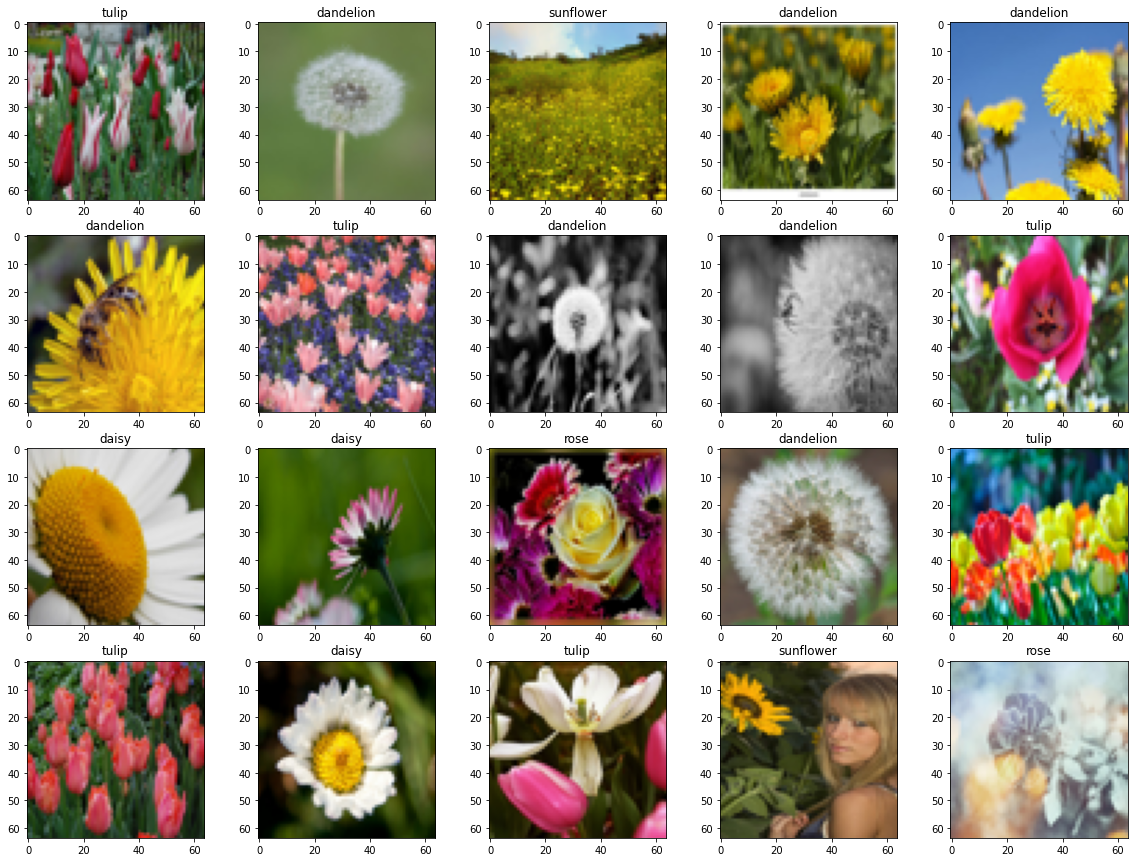

In [5]:
## Plot 20 random images that have been resized in the aprevious step
randomlist = random.sample(range(0, images.shape[0]), 20)
i = 1
for r in randomlist:
    plt.subplot(4,5,i).set_title('{}'.format(flowers[labels[r]]))
    plt.imshow(images[r,:,:,:])
    i += 1

These look pretty decent! It's time to prepare the data by flattening the image arrays and splitting the data into testing and training data.

### Data preparation and Train/Test Split

First thing we will want to do is one-hot encode the target values (i.e., labels).

In [6]:
## Define function that will one-hot encode the target values
def one_hot_encode(target):
    n_values = np.max(target) + 1
    one_hot = np.eye(n_values)[target]
    return(one_hot)

y = one_hot_encode(labels) # one-hot encode target values
X = images / np.max(images) # normalize input images

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (4317, 64, 64, 3)
y shape: (4317, 5)


Looks like we have 4,317 images to work with. It is time to perform a train/test split on the data. For now, I will try an 90/10 train/test split so that I will end up 3,885 images to train on and around 430 images to test on.

In [7]:
## Split X and y into training and test features + target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Quick sanity check to make sure we have the desired array shapes
print("X training shape:", X_train.shape)
print("y training shape:", y_train.shape)
print("X testing shape:", X_test.shape)
print("y testing shape:", y_test.shape)

X training shape: (3885, 64, 64, 3)
y training shape: (3885, 5)
X testing shape: (432, 64, 64, 3)
y testing shape: (432, 5)


## Build the model

Time to build the model! In the following block of code I add all the layers to the keras.Sequential(\[\]) model. First I will perform data augmentation. Then, the first hidden layer will perform a 2D convolution on the input data followed by a 2D max pooling. This process is repeated once more and then we add two dense layers with 512 units follwed by the output layer. I use dropout regularization to reduce overfitting.

In [8]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],X.shape[2],X.shape[3])),
    RandomFlip('horizontal'), # data augmentation
    RandomRotation(0.2),
    tfl.Conv2D(8, 4, strides=1, padding='same'),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=8, strides=8, padding='same'),
    tfl.Conv2D(16, 2, strides=1, padding='same'),
    tfl.ReLU(),
    tfl.MaxPool2D(pool_size=4,strides=4,padding='same'),
    tfl.Flatten(),
    tfl.Dense(512),
    tfl.Dropout(0.2),
    tfl.ReLU(),
    tfl.Dense(512),
    tfl.Dropout(0.2),
    tfl.ReLU(),
    tfl.Dense(units=len(flowers), activation='softmax')
])

2022-01-21 23:37:39.608282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 23:37:39.728664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 23:37:39.729332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 23:37:39.730745: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
## Define the optimizer, loss function, metric score and compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# View summary of model and trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 64, 64, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 16)          0

Let's fit the model!

In [10]:
## Define train and test data sets with batch size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

## Fit the model with 100 epochs
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100


2022-01-21 23:37:44.294228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 23:37:45.124744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


61/61 [==============================] - 7s 11ms/step - loss: 1.4123 - accuracy: 0.3634 - val_loss: 1.1974 - val_accuracy: 0.4769
Epoch 2/100
61/61 [==============================] - 1s 8ms/step - loss: 1.1066 - accuracy: 0.5333 - val_loss: 1.0864 - val_accuracy: 0.5370
Epoch 3/100
61/61 [==============================] - 1s 8ms/step - loss: 1.0280 - accuracy: 0.5650 - val_loss: 1.0962 - val_accuracy: 0.5486
Epoch 4/100
61/61 [==============================] - 1s 8ms/step - loss: 0.9684 - accuracy: 0.5964 - val_loss: 1.0873 - val_accuracy: 0.5671
Epoch 5/100
61/61 [==============================] - 1s 9ms/step - loss: 0.9456 - accuracy: 0.6121 - val_loss: 1.0409 - val_accuracy: 0.5787
Epoch 6/100
61/61 [==============================] - 1s 8ms/step - loss: 0.9374 - accuracy: 0.6178 - val_loss: 1.1007 - val_accuracy: 0.5694
Epoch 7/100
61/61 [==============================] - 1s 8ms/step - loss: 0.9185 - accuracy: 0.6216 - val_loss: 1.0576 - val_accuracy: 0.5880
Epoch 8/100
61/61 [=====

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

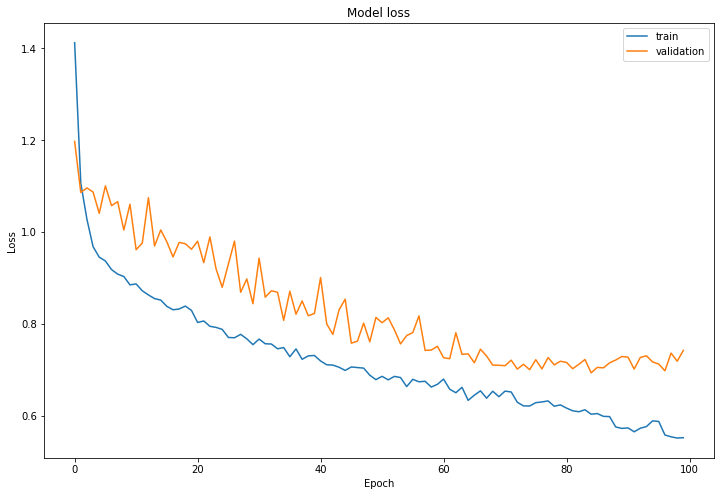

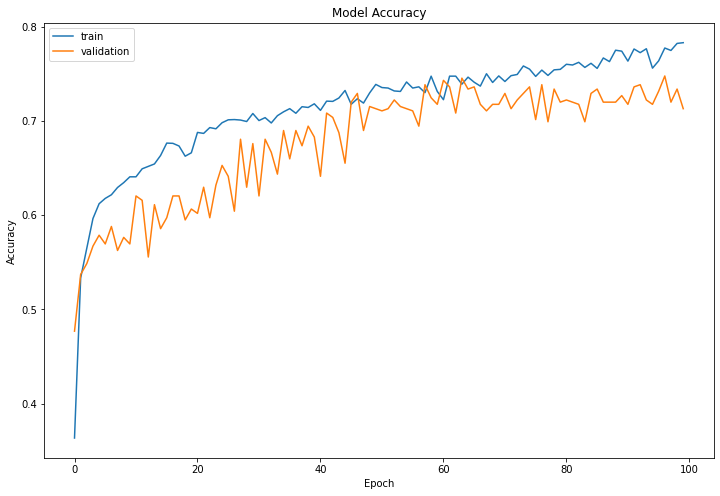

In [11]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

Not too bad. After running this several times the training accuracy always ends up at around 75-80% while the test accuracy typically ends up at around ~70%. Let's see if we can improve this with transfer learning.

# Transfer Learning

Let's use the [MobileNetV2](https://keras.io/api/applications/mobilenet/) model for this approach.
First I will start by defining a function that augments image data which we will call within the model.

In [12]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))    
    return data_augmentation

Let's build the model:

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #preprocess input with pre-trained weights

def transfer_model(image_shape=(64,64), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x * 255)
    x = base_model(x, training=False)   
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(len(flowers), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model
    


In [14]:
model2 = transfer_model()

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
# Define initial epochs and base_learning rate and then compile
initial_epochs = 50
base_lr = 0.001
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0     

In [16]:
history = model2.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset)

Epoch 1/50
61/61 [==============================] - 5s 30ms/step - loss: 1.3292 - accuracy: 0.5169 - val_loss: 1.0029 - val_accuracy: 0.6458
Epoch 2/50
61/61 [==============================] - 1s 17ms/step - loss: 0.9390 - accuracy: 0.6489 - val_loss: 0.9043 - val_accuracy: 0.6806
Epoch 3/50
61/61 [==============================] - 1s 16ms/step - loss: 0.8753 - accuracy: 0.6708 - val_loss: 0.8681 - val_accuracy: 0.6991
Epoch 4/50
61/61 [==============================] - 1s 16ms/step - loss: 0.8106 - accuracy: 0.7032 - val_loss: 0.8535 - val_accuracy: 0.6944
Epoch 5/50
61/61 [==============================] - 1s 16ms/step - loss: 0.7732 - accuracy: 0.7143 - val_loss: 0.8060 - val_accuracy: 0.7130
Epoch 6/50
61/61 [==============================] - 1s 17ms/step - loss: 0.7413 - accuracy: 0.7220 - val_loss: 0.7935 - val_accuracy: 0.7153
Epoch 7/50
61/61 [==============================] - 1s 17ms/step - loss: 0.7149 - accuracy: 0.7408 - val_loss: 0.7630 - val_accuracy: 0.7199
Epoch 8/50
61

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

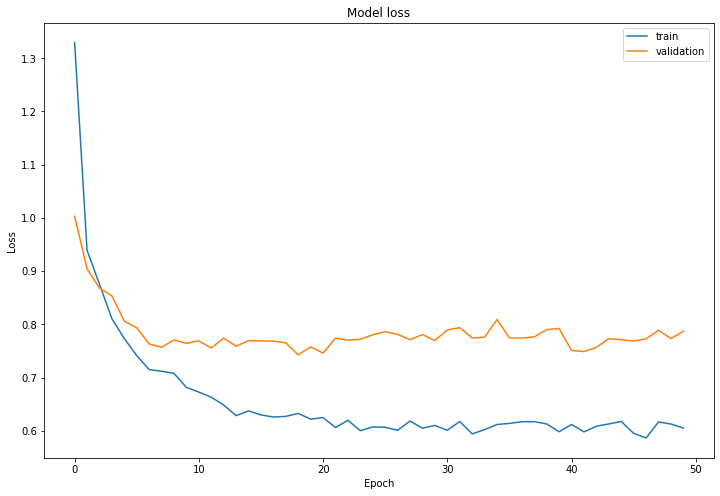

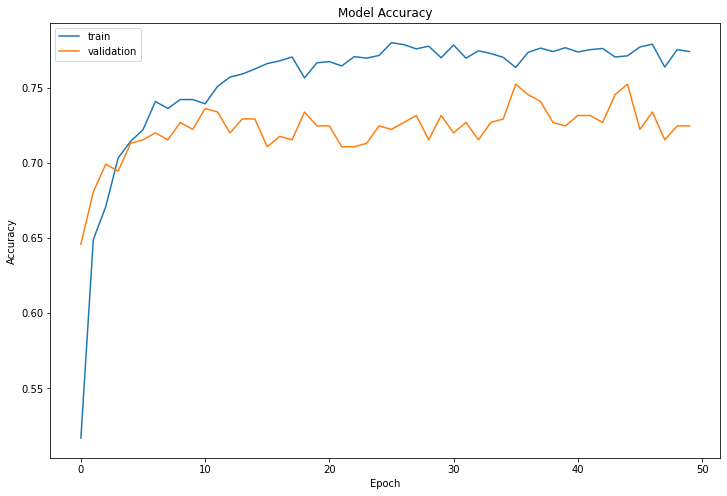

In [17]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

That was an improvement compared to before! Now let's do some fine tuning.

## Fine Tuning

Let's fine tune the model and see if we can improve the score. To do this, I will unfreeze the last few layers of the model and allow training with a smaller learning rate. 

In [18]:
model2.layers # See layers, freeze at base model (Functional)

In [19]:
base_model = model2.layers[5]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 120 # Start fine tuning at this layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr*0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()


Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooli

In [20]:
fine_tune_epochs = 30 # fine tune for 30 more epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)


Epoch 50/80
61/61 [==============================] - 5s 32ms/step - loss: 0.7846 - accuracy: 0.7140 - val_loss: 0.7178 - val_accuracy: 0.7199
Epoch 51/80
61/61 [==============================] - 1s 20ms/step - loss: 0.6529 - accuracy: 0.7557 - val_loss: 0.6850 - val_accuracy: 0.7269
Epoch 52/80
61/61 [==============================] - 1s 20ms/step - loss: 0.5766 - accuracy: 0.7797 - val_loss: 0.6690 - val_accuracy: 0.7477
Epoch 53/80
61/61 [==============================] - 1s 20ms/step - loss: 0.5395 - accuracy: 0.8000 - val_loss: 0.6176 - val_accuracy: 0.7593
Epoch 54/80
61/61 [==============================] - 1s 23ms/step - loss: 0.4933 - accuracy: 0.8144 - val_loss: 0.6348 - val_accuracy: 0.7755
Epoch 55/80
61/61 [==============================] - 1s 19ms/step - loss: 0.4809 - accuracy: 0.8190 - val_loss: 0.6312 - val_accuracy: 0.7824
Epoch 56/80
61/61 [==============================] - 2s 25ms/step - loss: 0.4393 - accuracy: 0.8373 - val_loss: 0.6674 - val_accuracy: 0.7778
Epoch 

Not a bad improvement! The test accuracy went from ~73% to ~82-83%.  To improve this, we could try adding other regularization techniques to the model to reduce overfitting and/or add more training data.